In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.

# Chapter4: アンサンブル学習

この章では, アンサンブル学習についての解説および簡単な実装を行う.

## 4.1 アンサンブル学習とは

アンサンブル学習とは, 弱学習器（性能は高くない分類器や回帰モデル）を複数構築し, それらを組み合わせることで予測精度を上げることを目指す学習手法の総称である.

「 三人寄れば文殊の知恵 」ということわざを体現したような手法となっている.

## 4.2 アンサンブル学習の代表的手法の紹介

アンサンブル学習には, 主に以下のような種類の方法がある. <br><br>

* **[バギング](#1.3)** : 個々の弱学習器の学習を**並列的に**行う手法 <br><br>

 * バギングをベースにした代表的なアルゴリズムに[ランダムフォレスト](#1.3.1)がある. <br><br>

* **[ブースティング](#1.4)** : 個々の弱学習器の学習を**直列的に**行う手法 <br><br>

 * ブースティングをベースにした代表的なアルゴリズムに[勾配ブースティング決定木](#1.4.1)がある. 

## 4.3 バギング
<a id="4.3"></a>

バギングとは, **ブーストラップ法により得られたデータセット用いて, 個々の弱学習器を並列的に学習させていく手法**である.<br>
そうして学習された弱学習器の出力の多数決（分類の場合）や平均（回帰の場合）を最終的な予測結果とする. <br><br>
**※ブーストラップ法**<br>
元の学習データから一部のデータを復元抽出（一度抽出したサンプルが再び抽出の対象となる方法）して, 別のデータセットを作るという操作を繰り返して, 新たなデータセットを複数作ること
<br><br>
並列する学習器の内容が全て同じでは, 多数決や平均を取る意味が無い. <br>
それぞれの学習器に個性を持たせるために, ブーストラップ法で得た内容が少しずつ異なるデータセットを用いて学習する.


### 4.3.1 ランダムフォレスト（RF）
<a id="4.3.1"></a>

ランダムフォレストとは, **決定木を弱学習器としたアンサンブル学習手法で, バギングを改良した手法**である.
<br><br>
ブーストラップ法の適用に加えて, 使用する特徴量をランダムに選択して各決定木を作成するという工夫を行うことで, 作成される決定木間の相関が低くなり, 通常のバギングよりも, **多様な決定木の作成を実現**している.


### 4.3.2 ランダムフォレストの使用例
<a id="4.3.2"></a>

### 4.3.2.1 データセットの準備

今回はペンギンデータセットを用いる.
<br>
タスクは３種類のペンギンを分類することである.（ヒゲペンギン・ジェンツーペンギン・アデリーペンギン）
![](./figs/peng.png)
今回使用する説明変数は以下の5つとする
* bill_length_mm（くちばしの長さ）
* bill_depth_mm（くちばしの高さ）
* flipper_length_mm（翼の長さ）
* body_mass_g（体重）
* year（観測年）

In [ ]:
!pip install palmerpenguins

In [2]:
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
# ペンギンデータセットの読み込み
penguin = load_penguins()

# 使用する説明変数の指定
usecols = [
  'species',
  'bill_length_mm',
  'bill_depth_mm',
  'flipper_length_mm',
  'body_mass_g',
  'year'
]
df1 = penguin[usecols].copy()
df1

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,39.1,18.7,181.0,3750.0,2007
1,Adelie,39.5,17.4,186.0,3800.0,2007
2,Adelie,40.3,18.0,195.0,3250.0,2007
3,Adelie,NaN,NaN,NaN,NaN,2007
4,Adelie,36.7,19.3,193.0,3450.0,2007
...,...,...,...,...,...,...
339,Chinstrap,55.8,19.8,207.0,4000.0,2009
340,Chinstrap,43.5,18.1,202.0,3400.0,2009
341,Chinstrap,49.6,18.2,193.0,3775.0,2009
342,Chinstrap,50.8,19.0,210.0,4100.0,2009


### 4.3.2.2 前処理

In [3]:
# 欠損値のあるデータを削除
df2=df1.dropna()
df2

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,39.1,18.7,181.0,3750.0,2007
1,Adelie,39.5,17.4,186.0,3800.0,2007
2,Adelie,40.3,18.0,195.0,3250.0,2007
4,Adelie,36.7,19.3,193.0,3450.0,2007
5,Adelie,39.3,20.6,190.0,3650.0,2007
...,...,...,...,...,...,...
339,Chinstrap,55.8,19.8,207.0,4000.0,2009
340,Chinstrap,43.5,18.1,202.0,3400.0,2009
341,Chinstrap,49.6,18.2,193.0,3775.0,2009
342,Chinstrap,50.8,19.0,210.0,4100.0,2009


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 目的変数を数値に変換
species_le = LabelEncoder()
df3=df2.copy()
df3['species'] = species_le.fit_transform(df2['species'])

# 目的変数
y=df3["species"]

# 説明変数
X=df3.drop("species", axis=1)

# 学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

### 4.3.2.3 モデルの定義・学習

In [5]:
from sklearn.ensemble import RandomForestClassifier

# 弱学習機（決定木）の個数を100個, 木の最大の深さを3に設定
model = RandomForestClassifier(n_estimators=100,max_depth=3)

# 学習
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

### 4.3.2.4 学習結果の確認

In [6]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9651162790697675


以下のコードを実行すると, 作成された各決定木を可視化することができます.
<br>
ただし, コードを実行し, 画像を生成するには,「Graphviz」というソフトウェアを別途インストールする必要がある.

In [6]:
"""
#決定木を可視化するツールを使用
import dtreeviz

estimators = model.estimators_
viz1 = dtreeviz.model(
    estimators[0],X,y,
    target_name='species',
    feature_names=df3.columns[1:].to_list(),
    class_names=penguin["species"].unique().tolist(),
)

viz2 = dtreeviz.model(
    estimators[1],X,y,
    target_name='species',
    feature_names=df3.columns[1:].to_list(),
    class_names=penguin["species"].unique().tolist(),
)
"""

'\n#決定木を可視化するツールを使用\nimport dtreeviz\n\nestimators = model.estimators_\nviz1 = dtreeviz.model(\n    estimators[0],X,y,\n    target_name=\'species\',\n    feature_names=df3.columns[1:].to_list(),\n    class_names=penguin["species"].unique().tolist(),\n)\n\nviz2 = dtreeviz.model(\n    estimators[1],X,y,\n    target_name=\'species\',\n    feature_names=df3.columns[1:].to_list(),\n    class_names=penguin["species"].unique().tolist(),\n)\n'

In [7]:
"""
# 複数の決定木のうち, 1つ目の決定木を可視化
viz1.view()
"""

'\n# 複数の決定木のうち, 1つ目の決定木を可視化\nviz1.view()\n'

In [8]:
"""
# 複数の決定木のうち, 2つ目の決定木を可視化
viz2.view()
"""

'\n# 複数の決定木のうち, 2つ目の決定木を可視化\nviz2.view()\n'

<br>
以上のコードを実行した結果, 表示される画像を以下に示す.

複数の決定木のうち, 1つ目の決定木を可視化


![](./figs/view_tree.png)
<br><br>

複数の決定木のうち, 2つ目の決定木を可視化
![](./figs/view_tree2.png)



これらのグラフを見ることで, それぞれの決定木がどのような基準で予測結果を出しているかを理解することができる.
<br>
また, それぞれ異なる決定木が作成されていることも確認することができる.

## 4.4 ブースティング
<a id="4.4"></a>

ブースティングとは, 個々の弱学習器を直列的に学習させていく手法である. 前の弱学習器の結果を参考にし, 予測値を補正するように次の弱学習器を学習させていく.<br>


### 4.4.1 勾配ブースティング決定木（GBDT）
<a id="4.4.1"></a>

勾配ブースティング決定木は, 決定木を弱学習器としたアンサンブル学習手法で, 誤差を逐次的に修正していくブースティングの一種である. 

この手法では, 最初の決定木が作成された後, その決定木が生じさせる誤差に対して次の決定木を訓練し, 誤差を小さくするように予測を更新していく. このプロセスを繰り返すことで, 性能が向上し, 過学習を抑えることが可能になる. 最終的な予測は, 各決定木の予測を重み付けした和として計算される.

### 4.4.2 勾配ブースティング決定木の使用例

[ランダムフォレストの使用例](#4.3.2)と同じ前処理をしたペンギンデータを使用して, 精度の比較を行ってみる.

### 4.4.2.1 モデルの定義・学習

勾配ブースティング決定木を扱えるフレームワークとして, LightGBMを使用する

In [ ]:
!pip install lightgbm

In [7]:
import lightgbm as lgb

params = {
    "objective": "multiclass",
    "metrics": "multi_error",
    "max_depth":3,
    "num_class": 3,
}

train_set = lgb.Dataset(X_train, y_train)
model2 = lgb.train(params, train_set)

y_pred = model2.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 5
[LightGBM] [Info] Start training from score -0.817790
[LightGBM] [Info] Start training from score -1.613352
[LightGBM] [Info] Start training from score -1.023389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [8]:
# テストデータで予測
y_pred = model2.predict(X_test, num_iteration=model2.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# Accuracy の計算
accuracy = sum(y_test == y_pred_max) / len(y_test)
print('accuracy:', accuracy)

accuracy: 0.9767441860465116


## 4.5 フルスクラッチコーディング

### 4.5.1 浅い決定木の実装

まずは最も単純な深さ1の決定木を作成してみよう．<br>
ジニ係数をもとにデータを二つに分ける基準を見つける．

ジニ係数とは，データのラベルがどれだけ統一されているかを示している．<br>
そして，データ集合内でラベルが同じものが多いほど，ジニ係数は小さくなる．<br>
極端な例を考えると，同じラベルが付いたデータのみのデータ集合のジニ係数は0である．<br>

あるデータ集合におけるジニ係数の計算は以下の式で表される．<br>
$ Gini=1-\sum^{K}_{k=1}p(k)^2$
- $K$はクラスの数
- $p(k)$はデータ集合内のクラス$k$の割合
<br>
<br>
実用上は，データ集合を二つに分割し，分割後の二つのデータ集合についてジニ係数を求める．そして，その期待値が小さいものをより良い分割条件であると定義する．

### 課題１.ジニ係数を求める関数を作成せよ

下記の関数を埋めることでジニ係数を求める関数を作成せよ．

In [9]:
#ジニ係数の計算を行う関数
def gini_score(data, target, feat_idx, threshold):
    
    gini = 0
    sample_num = len(target)
    
    #閾値をもとにデータを分ける
    div_target = [target[data[:, feat_idx] >= threshold], target[data[:, feat_idx] < threshold]]
    
    #閾値で分けたデータをもとにジニ係数を計算
    #(演習)プログラムを補完し，ジニ係数が計算できるようにせよ．
    for group in div_target:
        score = 0
        classes = np.unique(group)
        for cls in classes:
            p = np.sum(group == cls)/len(group)
            score += p * p
        gini += (1- score) * (len(group)/sample_num)
    
    return gini

In [10]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# irisデータセットの読み込み
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=['Species'])
df = pd.concat([X, y], axis=1)
# 品種 setosa、versicolorを抽出
df = df[(df['Species']==0) | (df['Species']==1)]
# 説明変数
X = df.iloc[:, [2,3]].values
# 目的変数
y = df.iloc[:, 4].values

下のセルを実行して、関数が正しくできているか確認しよう．
データが線で完全に分類できているほど関数の値は小さくなることがわかる．

0.019607843137254926


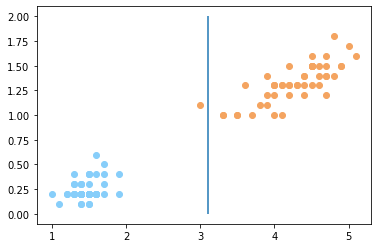

In [11]:
#データを分割する基準（数値を変更してみるとよい）
feat_idx=0
threshold=3.1

#関数の実行
print(gini_score(X, y, feat_idx, threshold))

#データ分割を図示する
if feat_idx==0:
    plt.vlines(x=threshold,ymin=int(min(X[:, 0]))-1,ymax=int(min(X[:, 0]))+1)
else:
    plt.hlines(y=threshold,xmin=int(min(X[:, 1]))-1,xmax=int(min(X[:, 1]))+1)
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], color='lightskyblue', label=data.target_names[0])
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], color='sandybrown', label=data.target_names[1])

### 課題2.ジニ係数をもとにベストなデータ分割を行う関数を作成せよ

決定木ではジニ係数をもとに最良のデータ分割を行う．下記の関数の穴埋めを行うことでデータ分割が行えるようにせよ．

In [12]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd


#最もよいデータの分類方法をジニ係数をもとに決定する
def search_best_split(data, target):   
    features = data.shape[1]
    best_thrs = None
    best_f = None
    gini = None
    gini_min = 1
    
    #すべての特徴量で探索
    for feat_idx in range(features):
        values = sorted(list(set(data[:, feat_idx])))
        values = [(values[i]+values[i-1])/2 for i in range(1,len(values))]
        #すべてのデータ点の値を閾値として探索
        for val in values:
            gini = gini_score(data, target, feat_idx, val)
            
            #より良いジニ係数であれば更新
            if gini_min > gini:
                gini_min = gini
                best_thrs = val
                best_f = feat_idx
                
    return gini_min, best_thrs, best_f       

#決定木のメイン処理
class DecisionTreeNode(object):
    def __init__(self, data, target):
        self.left = None
        self.right = None
        self.data = data
        self.target = target
        self.threshold = None
        self.feature = None
        self.gini_min = None
   
    def split(self):
        #最もよいデータの分割基準を探索
        self.gini_min, self.threshold, self.feature = search_best_split(self.data, self.target)
        
        #決定した基準をもとにデータを二つに分割する
        idx_left = self.data[:, self.feature] >= self.threshold
        idx_right = self.data[:, self.feature] < self.threshold
        
        #分割したそれぞれの条件に対して，どのラベルを付与するか決定
        #分割後のデータ集合で最も数の多いクラスに分類
        self.left = np.argmax(np.bincount(self.target[idx_left]))
        self.right = np.argmax(np.bincount(self.target[idx_right]))
 
    def predict(self, data):
        #条件を基に学習した結果を返す
        if data[self.feature] > self.threshold:
            return self.left
        else:
            return self.right

#決定木の根を表現
class my_DecisionTreeClassifier(object):
    def __init__(self):
        self.tree = None
   
    def fit(self, data, target):
        self.tree = DecisionTreeNode(data, target)
        self.tree.split()
   
    def predict(self, data):
        pred = []
        for s in data:
            pred.append(self.tree.predict(s))
        return np.array(pred)

では，実際に決定木を用いて分類を行ってみよう

[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
1.0


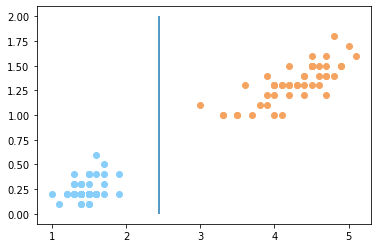

In [13]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics

# irisデータセットの読み込み
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=['Species'])
df = pd.concat([X, y], axis=1)
# 品種 setosa、versicolorを抽出
df = df[(df['Species']==0) | (df['Species']==1)]
# 説明変数
X = df.iloc[:, [2,3]].values
# 目的変数
y = df.iloc[:, 4].values
# 学習データと検証データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#決定木を呼び出し，学習を行う
clf = my_DecisionTreeClassifier()
clf.fit(X_train,y_train)

#学習結果を基に線を引く
if clf.tree.feature==0:
    plt.vlines(x=clf.tree.threshold,ymin=int(min(X[:, 0]))-1,ymax=int(min(X[:, 0]))+1)
else:
    plt.hlines(y=clf.tree.threshold,xmin=int(min(X[:, 1]))-1,xmax=int(min(X[:, 1]))+1)
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], color='lightskyblue', label=data.target_names[0])
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], color='sandybrown', label=data.target_names[1])

#予測結果の確認
y_pred=clf.predict(X_test)
print(y_pred)
#正解率の計算
print(metrics.accuracy_score(y_test, y_pred))

1本の線で二つのデータが分類できていれば，もっとも単純な決定木は完成である．<br>
今回のデータの場合は非常に単純なため，おそらく完全な分類に成功するはずだ．

### 4.5.2 一般的な決定木の実装

基本的には，浅い決定木と仕組みは同じである．<br>
ただし，先ほどのプログラムと違い，複数の分岐を行うには浅い決定木を複数積み上げた構造となっていることに注意する必要がある．<br>
つまり，条件で分岐させた後，特定のラベルを割り当てるのではなく，別の決定木の予測結果を割り当てる．

### 課題3.DecisionTreeNodeを完成させ，決定木を実装せよ[オプション課題]
DecisionTreeNodeのleft,rightには特定のラベルを割り当てていたが，この部分を新しいDecisionTreeNodeを割り当てるように変更すればよい．<br>
関数の再起呼び出しを利用するため少し難易度は高いが，ぜひ挑戦してみてほしい．

In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_moons
#ジニ係数の計算を行う
def gini_score(data, target, feat_idx, threshold):
    
    gini = 0
    sample_num = len(target)
    
    #閾値をもとにデータを分ける
    div_target = [target[data[:, feat_idx] >= threshold], target[data[:, feat_idx] < threshold]]
    
    #閾値で分けたデータをもとにジニ係数を計算
    #(演習)プログラムを補完し，ジニ係数が計算できるようにせよ．
    for group in div_target:
        score = 0
        classes = np.unique(group)
        for cls in classes:
            p = np.sum(group == cls)/len(group)
            score += p * p
        gini += (1- score) * (len(group)/sample_num)
    
    return gini

#最もよいデータの分類方法をジニ係数をもとに決定する
def search_best_split(data, target):   
    features = data.shape[1]
    best_thrs = None
    best_f = None
    gini = None
    gini_min = 1
    
    #すべての特徴量で探索
    for feat_idx in range(features):
        values = sorted(list(set(data[:, feat_idx])))
        values = [(values[i]+values[i-1])/2 for i in range(1,len(values))]
        #すべてのデータ点の値を閾値として探索
        for val in values:
            gini = gini_score(data, target, feat_idx, val)
            
            #より良いジニ係数であれば更新
            if gini_min > gini:
                gini_min = gini
                best_thrs = val
                best_f = feat_idx
    return gini_min, best_thrs, best_f         

#決定木のメイン処理
class DecisionTreeNode(object):
    def __init__(self, data, target,depth,max_depth,is_leaf=False):
        self.left = None
        self.right = None
        self.data = data
        self.target = target
        self.threshold = None
        self.feature = None
        self.gini_min = None
        
        #深さの管理用
        self.max_depth = max_depth
        self.depth = depth
        self.is_leaf = is_leaf
        self.label = np.argmax(np.bincount(target))
    def split(self):
        #同じラベルのデータしか含まれないなら分割を終了
        if len(self.target)==max(np.bincount(self.target)):
            self.leaf=True
            
        #最もよいデータの分割基準を探索
        self.gini_min, self.threshold, self.feature = search_best_split(self.data, self.target)
        #決定した基準をもとにデータを二つに分割する
        idx_left = self.data[:, self.feature] >= self.threshold
        idx_right = self.data[:, self.feature] < self.threshold
        
        #深さが最大に達するか、分割の必要がない場合は終了
        if self.depth==self.max_depth-1 or self.gini_min==0:
            #分割したそれぞれの条件に対して，どのラベルを付与するか決定
            #分割後のデータ集合で最も数の多いクラスに分類
            self.left = DecisionTreeNode(self.data[idx_left],  self.target[idx_left],self.depth+1, self.max_depth,True)
            self.right = DecisionTreeNode(self.data[idx_right],  self.target[idx_right],self.depth+1, self.max_depth,True)
        #分岐を続ける
        else:
            self.left = DecisionTreeNode(self.data[idx_left],  self.target[idx_left],self.depth+1, self.max_depth)
            if len(set(self.target[idx_left]))>1:
                self.left.split()
            else:
                self.left.is_leaf = True
            
            self.right = DecisionTreeNode(self.data[idx_right],  self.target[idx_right],self.depth+1, self.max_depth)
            if len(set(self.target[idx_right]))>1:
                self.right.split()
            else:
                self.right.is_leaf = True
            
    def predict(self, data):
        #葉に到達した場合
        if self.is_leaf:
            return self.label
        
        #条件を基に学習した結果を返す
        if data[self.feature] >= self.threshold:
            return self.left.predict(data)
        else:
            return self.right.predict(data)

#決定木の根を表現
class my_DecisionTreeClassifier(object):
    def __init__(self,max_depth):
        self.tree = None
        
        #深さを表すパラメータ
        self.max_depth = max_depth
        
    def fit(self, data, target):
        #最初の深さは0
        initial_depth = 0
        self.tree = DecisionTreeNode(data,target,initial_depth,self.max_depth)
        self.tree.split()
   
    def predict(self, data):
        pred = []
        for s in data:
            pred.append(self.tree.predict(s))
        return np.array(pred)

In [15]:
moon = make_moons(n_samples=200, noise=0.1, random_state=0)
X = moon[0]
y = moon[1]

# 学習データと検証データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = my_DecisionTreeClassifier(max_depth=8)
clf.fit(X_train, y_train)

#学習データに対する予測
y_pred = clf.predict(X_train)
score = sum(y_pred == y_train)/float(len(y_train))
print('Classification accuracy: {}'.format(score))

#テストデータに対する予測
y_pred = clf.predict(X_test)
score = sum(y_pred == y_test)/float(len(y_test))
print('Classification accuracy: {}'.format(score))

Classification accuracy: 1.0
Classification accuracy: 0.98


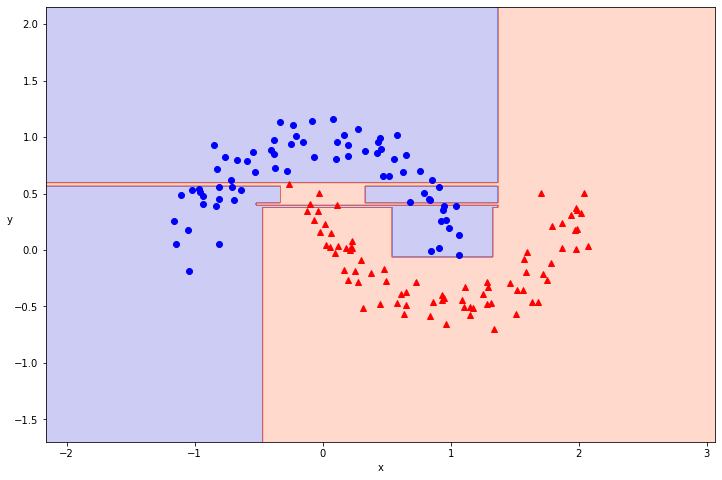

In [16]:
import matplotlib.pyplot as plt # グラフ等の描画用モジュール
from matplotlib.colors import ListedColormap # 描画時のカラー指定に使用
# 学習結果の可視化
def plot_decision_boundary(model, x, t):
    # サンプルデータのプロット
    plt.plot(x[:, 0][t==0], x[:, 1][t==0], 'bo')
    plt.plot(x[:, 0][t==1], x[:, 1][t==1], 'r^')
    plt.xlabel('x') # x 軸方向に x を表示
    plt.ylabel('y', rotation=0) # y 軸方向に y を表示
    
    # 描画範囲の設定
    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    
    # 用意した間隔を使用してグリッドを作成
    _x, _y = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                   np.arange(x2_min, x2_max, 0.01))
    
    # 多次元配列の結合
    xy = np.array([_x.ravel(), _y.ravel()]).T
    # 予測結果を算出し、分類境界線を図示
    y_pred = model.predict(xy).reshape(_x.shape)
    custom_cmap = ListedColormap(['mediumblue', 'orangered'])
    plt.contourf(_x, _y, y_pred, cmap=custom_cmap, alpha=0.2)

plt.figure(figsize=(12, 8))
plot_decision_boundary(clf, X_train, y_train)

これで決定木の実装が完了した．
ここで作成したクラスを利用して，ランダムフォレストの実装を行っていく．

### 4.5.3 ランダムフォレストの実装

### 課題4.my_RandomForestClassifierを完成させ，ランダムフォレストを実装せよ．
ランダムフォレストでは，異なるデータ集合を用いた決定木を用意して予測を行う．<br>
今回は以下のようなランダムフォレストを構成する．
1. ブートストラップを利用して，異なるデータ集合を作成
2. それぞれのデータ集合を使用して複数の決定木を学習する
3. すべての決定木の結果の多数決を予測結果とする

もしフルスクラッチで決定木の実装ができていない場合は，scikit-learnの決定木を利用することとする．
ブートストラップでは単純に全データ集合からランダムにサンプリングを行う処理を実現すればよい．

In [17]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import random

#決定木をフルスクラッチで実装した場合は先に実行しておく

#ランダムフォレストのフルスクラッチ
class my_RandomForestClassifier(object):
    def __init__(self,tree_num,sample_num,max_depth):
        self.trees = []
        self.datas = []
        self.tree_num = tree_num
        self.sample_num = sample_num
        self.max_depth = max_depth
        
    def fit(self, data, target):
        for _ in range(self.tree_num):
            sample_idx = [random.randint(0,len(data)-1) for _ in range(self.sample_num)]
            sample_data = data[sample_idx]
            sample_target = target[sample_idx]
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            #もしフルスクラッチを完成させていたら，コメントアウト
            #tree = my_DecisionTreeClassifier(self.max_depth)
            tree.fit(sample_data,sample_target)
            self.trees.append(tree)
            self.datas.append([sample_data,sample_target])
            
    def predict(self, data):
        results=[]
        for tree in self.trees:
            results.append(tree.predict(data))
        pred = []
        for counter in list(zip(*results)):
            pred.append(np.argmax(np.bincount(counter)))
        return np.array(pred)

In [18]:
moon = make_moons(n_samples=200, noise=0.1, random_state=0)
X = moon[0]
y = moon[1]

# 学習データと検証データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = my_RandomForestClassifier(tree_num=8,sample_num=len(X_train)//2,max_depth=2)
clf.fit(X_train, y_train)

#学習データに対する予測
y_pred = clf.predict(X_train)
score = sum(y_pred == y_train)/float(len(y_train))
print('Classification accuracy: {}'.format(score))

#テストデータに対する予測
y_pred = clf.predict(X_test)
score = sum(y_pred == y_test)/float(len(y_test))
print('Classification accuracy: {}'.format(score))

Classification accuracy: 0.9266666666666666
Classification accuracy: 0.96


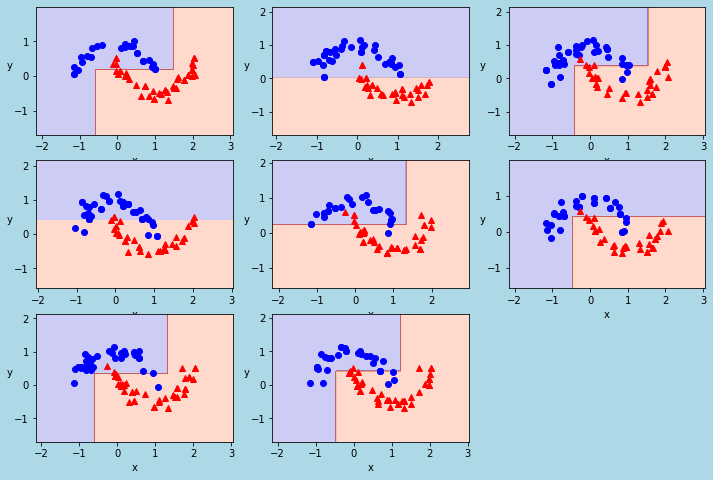

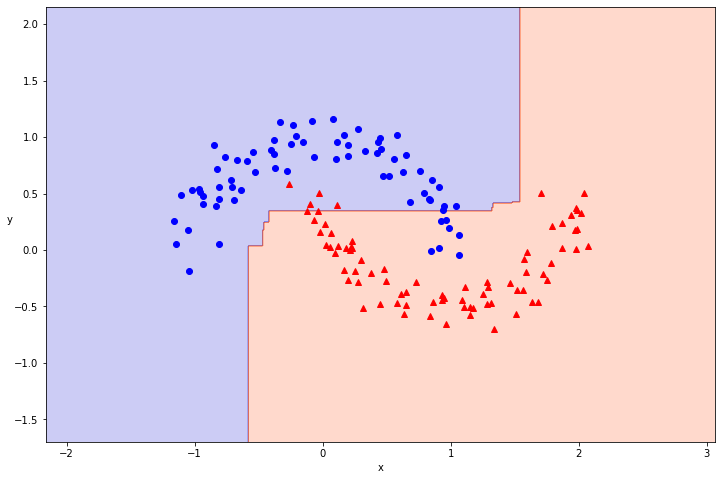

In [19]:
import matplotlib.pyplot as plt # グラフ等の描画用モジュール
from matplotlib.colors import ListedColormap # 描画時のカラー指定に使用
# 学習結果の可視化
def plot_decision_boundary(model, x, t):
    # サンプルデータのプロット
    plt.plot(x[:, 0][t==0], x[:, 1][t==0], 'bo')
    plt.plot(x[:, 0][t==1], x[:, 1][t==1], 'r^')
    plt.xlabel('x') # x 軸方向に x を表示
    plt.ylabel('y', rotation=0) # y 軸方向に y を表示
    
    # 描画範囲の設定
    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    
    # 用意した間隔を使用してグリッドを作成
    _x, _y = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                   np.arange(x2_min, x2_max, 0.01))
    
    # 多次元配列の結合
    xy = np.array([_x.ravel(), _y.ravel()]).T
    # 予測結果を算出し、分類境界線を図示
    y_pred = model.predict(xy).reshape(_x.shape)
    custom_cmap = ListedColormap(['mediumblue', 'orangered'])
    plt.contourf(_x, _y, y_pred, cmap=custom_cmap, alpha=0.2)
fig = plt.figure(figsize = (12,8), facecolor='lightblue')
row = len(clf.trees)//3+1
for n in range(len(clf.trees)):
    ax = fig.add_subplot(row, 3, n+1)
    plot_decision_boundary(clf.trees[n], clf.datas[n][0],clf.datas[n][1])
plt.figure(figsize=(12, 8))
plot_decision_boundary(clf, X_train, y_train)

データの選択によって様々な木が構成されており，その結果をアンサンブルで得ることができた．<br>
パラメータなども変更しつつ，実際にどのように挙動が変わるか見てみるとよい．